## Downloading the dataset

In [1]:
import os
if not os.path.exists('/kaggle/working/personA'):
    !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
    !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
    !unzip -q person_images.zip
!pip install lovely-tensors --quiet
!pip install -q torch_snippets torch_summary --quiet
from torch_snippets import *
import torch
from random_warp import get_training_data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

## Making a function for getting the cropped face only

In [3]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [4]:
if os.path.isdir('/kaggle/working/cropped_faces_personB'):
    !rm -rf /kaggle/working/cropped_faces_personB
    !rm -rf /kaggle/working/cropped_faces_personA
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i],1)
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

## Defining our Dataset

In [5]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

## Defining a Convolution Block and Upscaling Block 
### To use in making the AutoEncoder

In [6]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

## How normal faces are generated from their respective latent spaces

![AutoEncoder](https://www.alanzucconi.com/wp-content/uploads/2018/03/deepfakes_01d.png)

## The AutoEncoder with an encoding block and two decoding blocks

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

## How we Aim to Generate Deepfakes by using a different latent space

![](https://www.alanzucconi.com/wp-content/uploads/2018/03/deepfakes_02d.png)

In [8]:
from torchsummary import summary
model = Autoencoder()
summary(model, torch.zeros(32,3,64,64), 'A');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         9,728
|    |    └─LeakyReLU: 3-2               [-1, 128, 32, 32]         --
|    └─Sequential: 2-2                   [-1, 256, 16, 16]         --
|    |    └─Conv2d: 3-3                  [-1, 256, 16, 16]         819,456
|    |    └─LeakyReLU: 3-4               [-1, 256, 16, 16]         --
|    └─Sequential: 2-3                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-5                  [-1, 512, 8, 8]           3,277,312
|    |    └─LeakyReLU: 3-6               [-1, 512, 8, 8]           --
|    └─Sequential: 2-4                   [-1, 1024, 4, 4]          --
|    |    └─Conv2d: 3-7                  [-1, 1024, 4, 4]          13,108,224
|    |    └─LeakyReLU: 3-8               [-1, 1024, 4, 4]     

## Defining the train step

In [9]:
def train_batch(model, data, criterion, optimizes):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [10]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
             
criterion = nn.L1Loss()

## Training the model (train for atleast 10000 epochs. I have done till 500)

EPOCH: 10.000  lossB: 0.099  lossA: 0.090  (10.58s - 518.24s remaining)
EPOCH: 20.000  lossB: 0.100  lossA: 0.092  (19.14s - 459.48s remaining)
EPOCH: 30.000  lossB: 0.086  lossA: 0.091  (28.23s - 442.28s remaining)
EPOCH: 40.000  lossB: 0.082  lossA: 0.091  (37.02s - 425.71s remaining)
EPOCH: 50.000  lossB: 0.074  lossA: 0.085  (45.88s - 412.89s remaining)
EPOCH: 60.000  lossB: 0.071  lossA: 0.080  (54.66s - 400.85s remaining)
EPOCH: 70.000  lossB: 0.068  lossA: 0.075  (63.73s - 391.51s remaining)
EPOCH: 80.000  lossB: 0.063  lossA: 0.067  (72.51s - 380.70s remaining)
EPOCH: 90.000  lossB: 0.055  lossA: 0.065  (81.24s - 370.10s remaining)
EPOCH: 100.000  lossB: 0.054  lossA: 0.063  (90.12s - 360.49s remaining)


══════════════════════════════A TO B══════════════════════════════

Row1: Original A
Row2: Reconstructed A
Row3: Reconstructed B

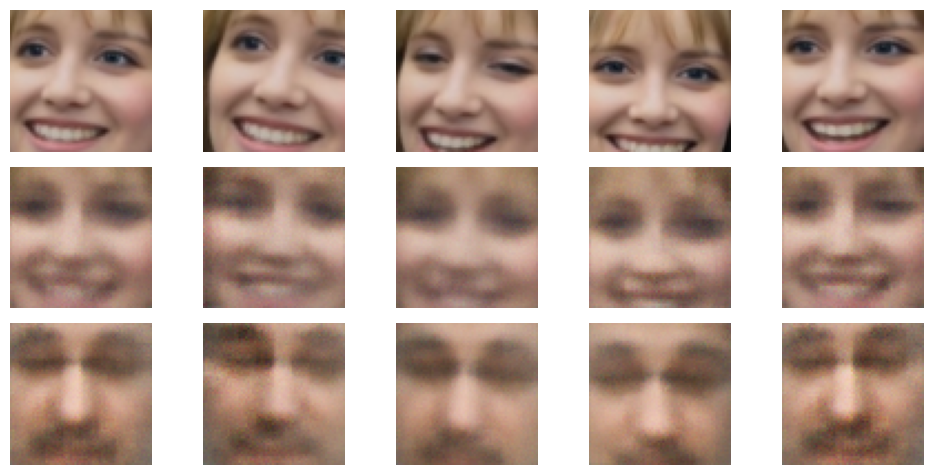

══════════════════════════════B TO A══════════════════════════════

Row1: Original B
Row2: Reconstructed A
Row3: Reconstructed B

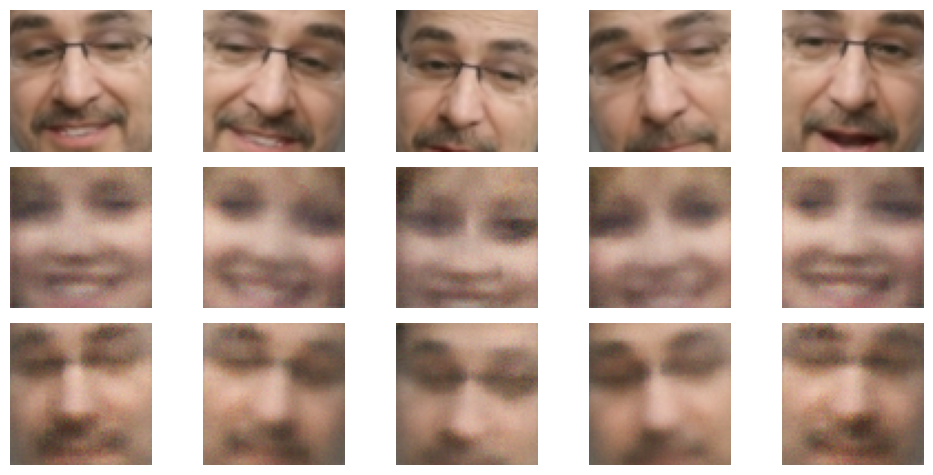

EPOCH: 110.000  lossB: 0.051  lossA: 0.060  (100.93s - 357.86s remaining)
EPOCH: 120.000  lossB: 0.050  lossA: 0.058  (109.56s - 346.96s remaining)
EPOCH: 130.000  lossB: 0.046  lossA: 0.056  (118.25s - 336.55s remaining)
EPOCH: 140.000  lossB: 0.047  lossA: 0.053  (127.33s - 327.41s remaining)
EPOCH: 150.000  lossB: 0.044  lossA: 0.053  (135.95s - 317.21s remaining)
EPOCH: 160.000  lossB: 0.044  lossA: 0.050  (144.77s - 307.64s remaining)
EPOCH: 170.000  lossB: 0.044  lossA: 0.051  (153.89s - 298.73s remaining)
EPOCH: 180.000  lossB: 0.043  lossA: 0.048  (162.85s - 289.52s remaining)
EPOCH: 190.000  lossB: 0.043  lossA: 0.048  (171.65s - 280.06s remaining)
EPOCH: 200.000  lossB: 0.040  lossA: 0.048  (180.38s - 270.57s remaining)


══════════════════════════════A TO B══════════════════════════════

Row1: Original A
Row2: Reconstructed A
Row3: Reconstructed B

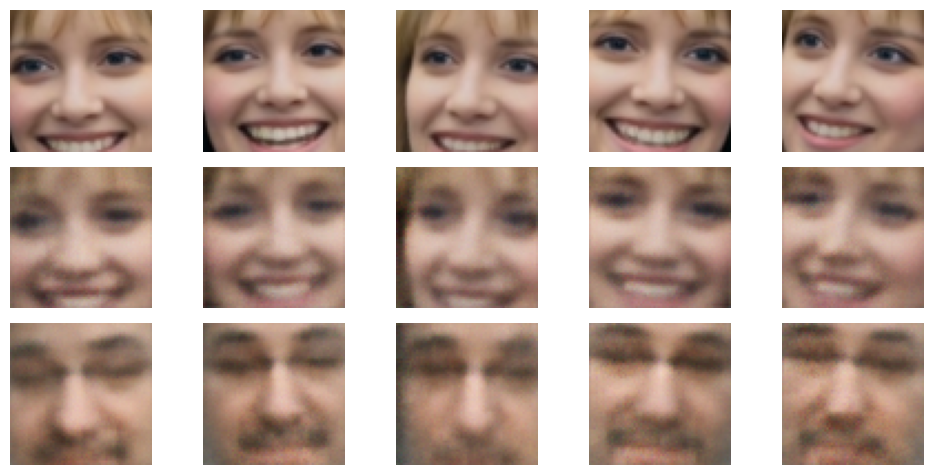

══════════════════════════════B TO A══════════════════════════════

Row1: Original B
Row2: Reconstructed A
Row3: Reconstructed B

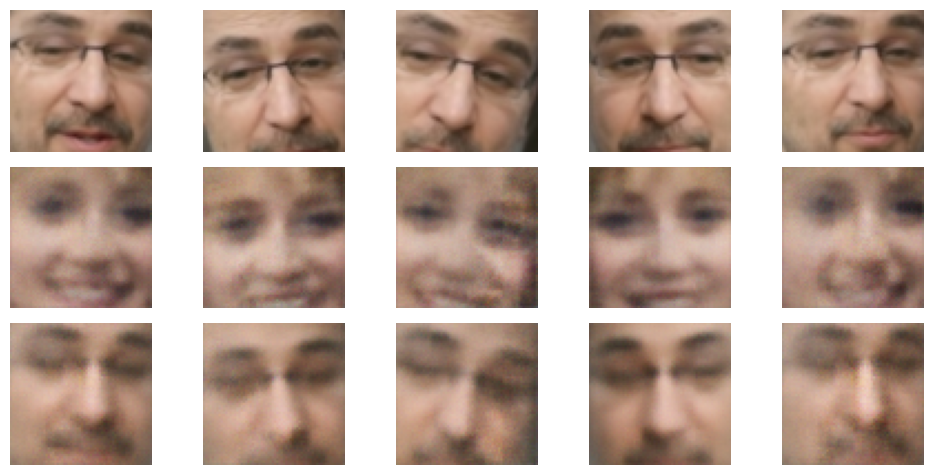

EPOCH: 210.000  lossB: 0.039  lossA: 0.047  (192.09s - 265.26s remaining)
EPOCH: 220.000  lossB: 0.038  lossA: 0.046  (200.98s - 255.79s remaining)
EPOCH: 230.000  lossB: 0.038  lossA: 0.045  (209.91s - 246.41s remaining)
EPOCH: 240.000  lossB: 0.037  lossA: 0.044  (219.18s - 237.44s remaining)
EPOCH: 250.000  lossB: 0.037  lossA: 0.043  (227.90s - 227.90s remaining)
EPOCH: 260.000  lossB: 0.038  lossA: 0.043  (236.60s - 218.40s remaining)
EPOCH: 270.000  lossB: 0.035  lossA: 0.043  (245.35s - 209.01s remaining)
EPOCH: 280.000  lossB: 0.034  lossA: 0.043  (254.64s - 200.08s remaining)
EPOCH: 290.000  lossB: 0.034  lossA: 0.040  (263.51s - 190.82s remaining)
EPOCH: 300.000  lossB: 0.033  lossA: 0.040  (272.21s - 181.47s remaining)


══════════════════════════════A TO B══════════════════════════════

Row1: Original A
Row2: Reconstructed A
Row3: Reconstructed B

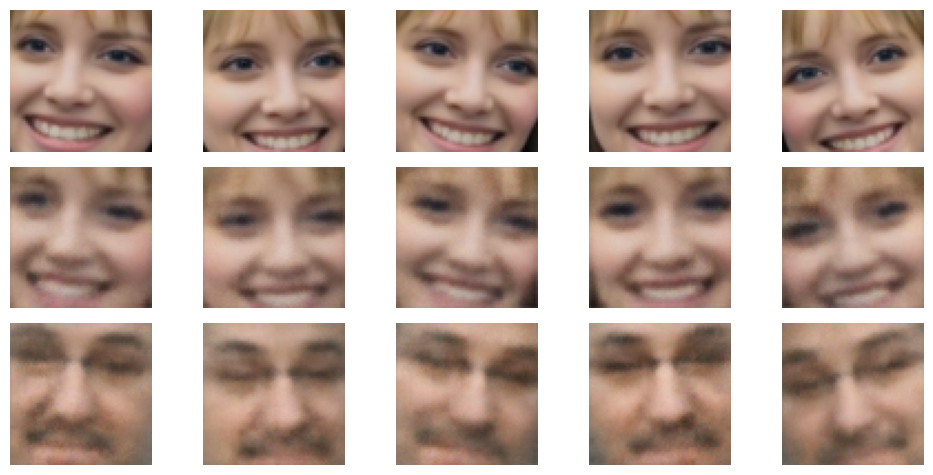

══════════════════════════════B TO A══════════════════════════════

Row1: Original B
Row2: Reconstructed A
Row3: Reconstructed B

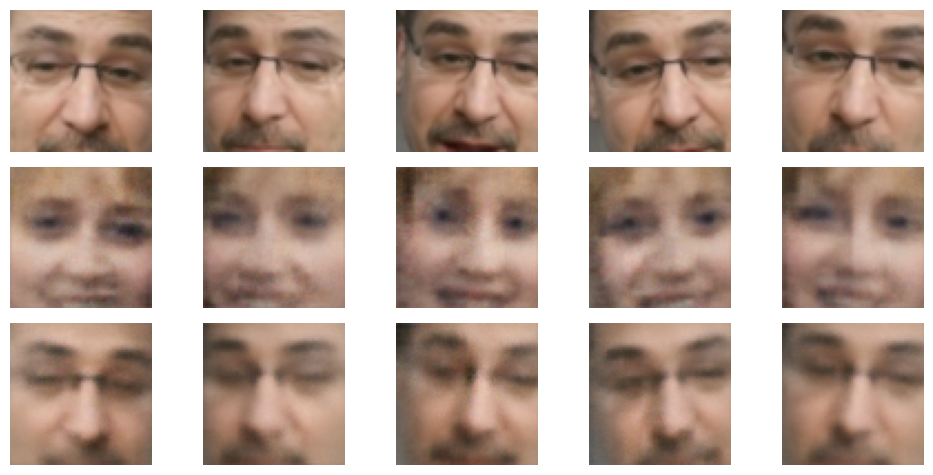

EPOCH: 310.000  lossB: 0.035  lossA: 0.040  (283.46s - 173.73s remaining)
EPOCH: 320.000  lossB: 0.035  lossA: 0.039  (292.13s - 164.33s remaining)
EPOCH: 330.000  lossB: 0.034  lossA: 0.040  (300.68s - 154.90s remaining)
EPOCH: 340.000  lossB: 0.035  lossA: 0.039  (309.25s - 145.53s remaining)
EPOCH: 350.000  lossB: 0.033  lossA: 0.037  (318.12s - 136.34s remaining)
EPOCH: 360.000  lossB: 0.033  lossA: 0.038  (326.67s - 127.04s remaining)
EPOCH: 370.000  lossB: 0.034  lossA: 0.038  (335.33s - 117.82s remaining)
EPOCH: 380.000  lossB: 0.033  lossA: 0.040  (344.19s - 108.69s remaining)
EPOCH: 390.000  lossB: 0.032  lossA: 0.035  (352.76s - 99.50s remaining)
EPOCH: 400.000  lossB: 0.032  lossA: 0.039  (361.38s - 90.35s remaining)


══════════════════════════════A TO B══════════════════════════════

Row1: Original A
Row2: Reconstructed A
Row3: Reconstructed B

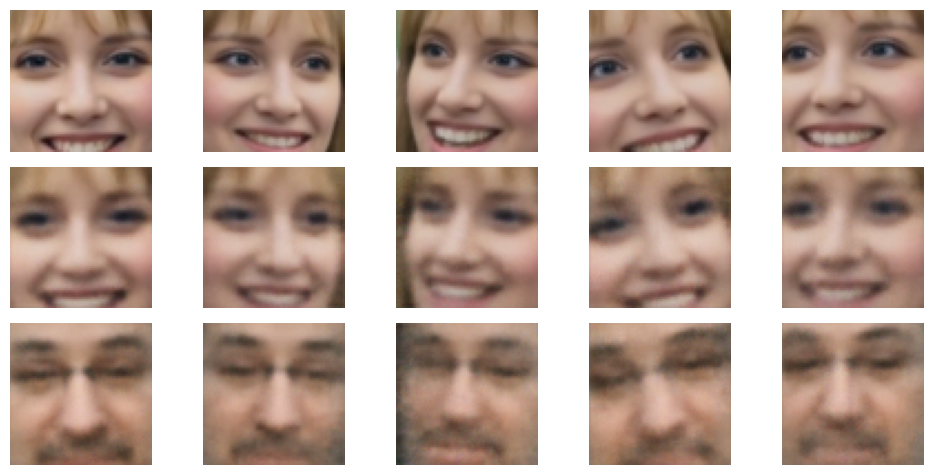

══════════════════════════════B TO A══════════════════════════════

Row1: Original B
Row2: Reconstructed A
Row3: Reconstructed B

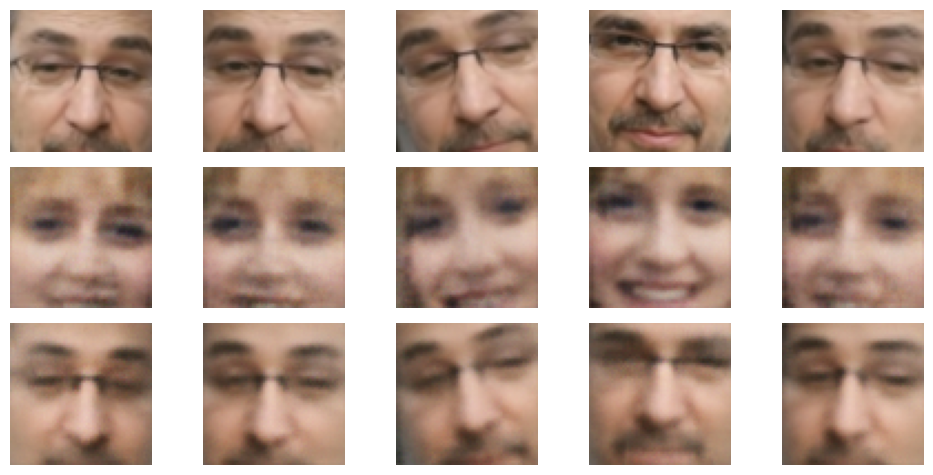

EPOCH: 410.000  lossB: 0.032  lossA: 0.037  (372.78s - 81.83s remaining)
EPOCH: 420.000  lossB: 0.031  lossA: 0.037  (381.90s - 72.74s remaining)
EPOCH: 430.000  lossB: 0.030  lossA: 0.037  (390.53s - 63.57s remaining)
EPOCH: 440.000  lossB: 0.031  lossA: 0.037  (399.22s - 54.44s remaining)
EPOCH: 450.000  lossB: 0.031  lossA: 0.037  (408.21s - 45.36s remaining)
EPOCH: 460.000  lossB: 0.032  lossA: 0.037  (416.92s - 36.25s remaining)
EPOCH: 470.000  lossB: 0.031  lossA: 0.035  (425.70s - 27.17s remaining)
EPOCH: 480.000  lossB: 0.030  lossA: 0.035  (434.45s - 18.10s remaining)
EPOCH: 490.000  lossB: 0.030  lossA: 0.033  (443.60s - 9.05s remaining)
EPOCH: 500.000  lossB: 0.030  lossA: 0.034  (452.29s - 0.00s remaining)


══════════════════════════════A TO B══════════════════════════════

Row1: Original A
Row2: Reconstructed A
Row3: Reconstructed B

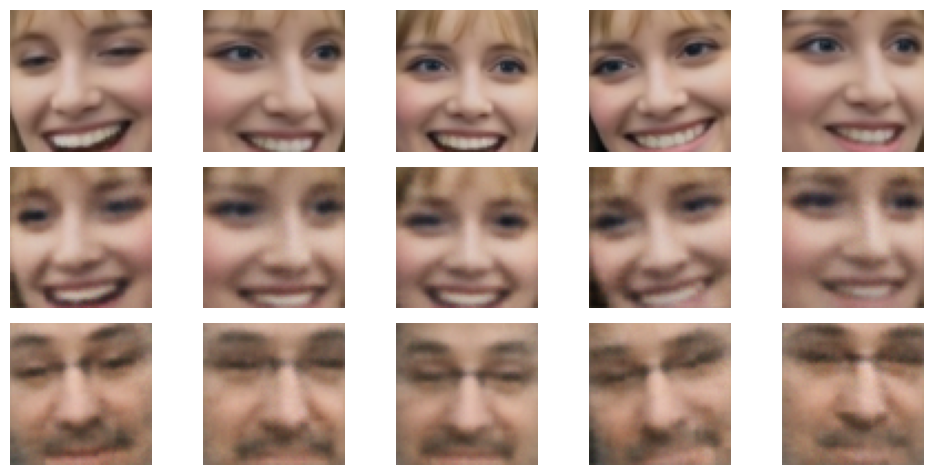

══════════════════════════════B TO A══════════════════════════════

Row1: Original B
Row2: Reconstructed A
Row3: Reconstructed B

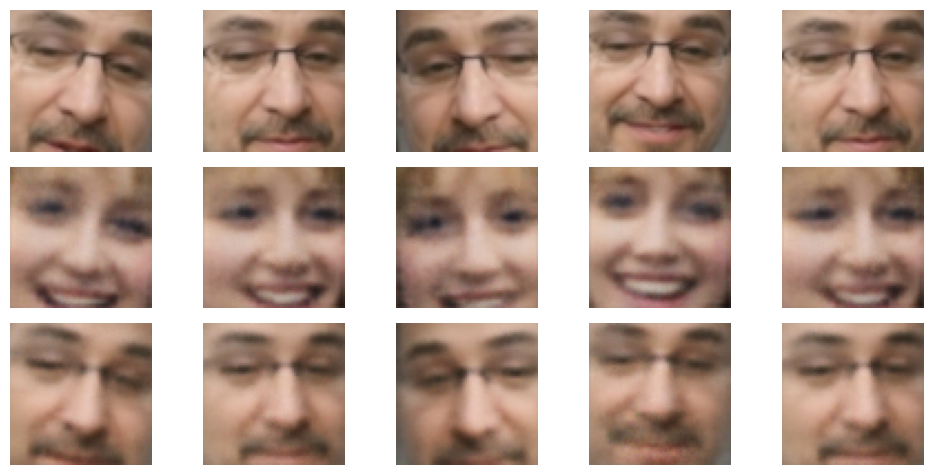

100%|██████████| 601/601 [00:00<00:00, 1333.06it/s]


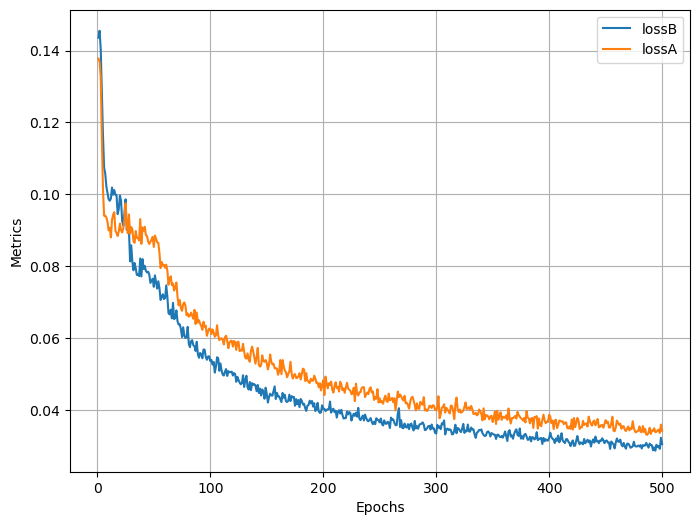

In [11]:
n_epochs = 500
if os.path.isdir('/kaggle/working/checkpoint'):
    !rm -rf /kaggle/working/checkpoint
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    if not (ex+1)%10: log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b]).cpu().detach().numpy()
        print("Row1: Original A\nRow2: Reconstructed A\nRow3: Reconstructed B")
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        print("Row1: Original B\nRow2: Reconstructed A\nRow3: Reconstructed B")
        x = torch.cat([B[:bs],_a,_b]).cpu().detach().numpy()
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()